In [1]:
import numpy as np
import os
from kan import *
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


导入数据并随机采样
The name and unit of each feature of 2) were listed in sequence as follows:
1. Snow depth / ground roughness (=0.01m)
2. 1 / snow density
3. Snow water equivalent / max value of snow water equivalent
4. Air temperature / 273.15
5. Specific humidity
6. 200 / Standard deviation of sub-grid topography

The name and unit of target were listed as follows:
1. Snow cover fraction [%]

In [5]:
data_loc=r"D:\Data\snow_cover_V2"
x_test=np.load(os.path.join(data_loc,"x_test_d.npy"),mmap_mode="r")
y_test=np.load(os.path.join(data_loc,"y_test_d.npy"),mmap_mode="r")
x_train=np.load(os.path.join(data_loc,"x_train_d.npy"),mmap_mode="r")
y_train=np.load(os.path.join(data_loc,"y_train_d.npy"),mmap_mode="r")
# print("x_test_d's shape is",x_test.shape)
# print("y_test_d's shape is",y_test.shape)
# print("x_train_d's shape is",x_train.shape)
# print("y_train_d's shape is",y_train.shape)
# 进行随机采样，采样 0.1% 的数据
sample_size = int(0.001 * len(x_train))
sample_indices = np.random.choice(len(x_train), size=sample_size, replace=False)
x_train_sample = x_train[sample_indices]
y_train_sample = y_train[sample_indices]

sample_size2 = int(0.001 * len(x_test))
sample_indices2 = np.random.choice(len(x_test), size=sample_size2, replace=False)
x_test_sample = x_test[sample_indices2]
y_test_sample = y_test[sample_indices2]
# print(x_train_sample.shape)  # 输出采样后的数据形状
# print(y_train_sample.shape)
# print(x_test_sample.shape)  
# print(y_test_sample.shape)

制作数据集

In [6]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, x_test, y_test, test_size=0.2, random_state=42):
        """
        初始化数据集，使用x_sample和y_sample划分为训练和测试集
        :param x_sample: 特征的numpy数组
        :param y_sample: 标签的numpy数组
        :param test_size: 测试集比例
        :param random_state: 随机种子
        """
        # # 划分训练集和测试集
        # x_train, x_test, y_train, y_test = train_test_split(
        #     x_sample, y_sample, test_size=test_size, random_state=random_state
        # )

        # 将划分好的数据转为Tensor
        # 存储数据集，使用 torch.tensor 从 NumPy 数组或其他格式转换为张量，并将其移动到指定设备（如 GPU）。
        self.data_dict = {
            'train_input': torch.tensor(x_train, dtype=torch.float32).to(device=device),
            'train_label': torch.tensor(y_train, dtype=torch.float32).to(device=device),
            'test_input': torch.tensor(x_test, dtype=torch.float32).to(device=device),
            'test_label': torch.tensor(y_test, dtype=torch.float32).to(device=device)
        }

    def __len__(self):
        # 返回训练数据的长度
        return len(self.data_dict['train_label'])

    def __getitem__(self, idx):
        # 根据索引返回训练数据和标签
        return {
            'train_input': self.data_dict['train_input'][idx],
            'train_label': self.data_dict['train_label'][idx],
            'test_input': self.data_dict['test_input'][idx % len(self.data_dict['test_input'])],  # 循环访问测试数据
            'test_label': self.data_dict['test_label'][idx % len(self.data_dict['test_label'])]   # 循环访问测试标签
        }


In [7]:
# 实例化数据集
dataset = CustomDataset(x_train_sample,y_train_sample,x_test_sample,y_test_sample)
# 创建数据加载器
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

# print(dataloader)
# # 验证数据集
# for batch_data in dataloader:
#     print(batch_data["test_label"])
#     break  # 只打印第一个批次

初始化

checkpoint directory created: ./model
saving model version 0.0


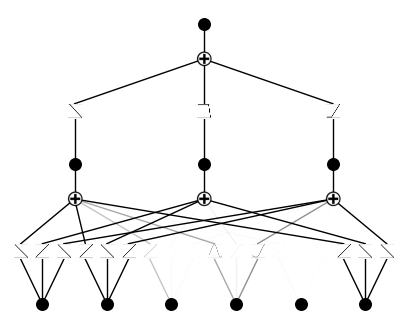

In [8]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[6,3,1], grid=5, k=3, seed=0,device=device)
model(dataset.data_dict["train_input"])
model.plot(beta=100)

标准

In [27]:
# 计算训练集的平均误差（MAE）
def train_mae():
    # 计算预测值和真实值之间的绝对误差
    errors = torch.abs(model(dataset.data_dict['train_input'])[:, 0] - dataset.data_dict['train_label'][:, 0])
    # 计算绝对误差的平均值
    return torch.mean(errors)

# 计算测试集的平均误差（MAE）
def test_mae():
    # 计算预测值和真实值之间的绝对误差
    errors = torch.abs(model(dataset.data_dict['test_input'])[:, 0] - dataset.data_dict['test_label'][:, 0])
    # 计算绝对误差的平均值
    return torch.mean(errors)

#计算均方差（MSE）
def train_mse():
    errors = (model(dataset.data_dict['train_input'])[:, 0] - dataset.data_dict['train_label'][:, 0]) ** 2
    return torch.mean(errors)

def test_mse():
    errors = (model(dataset.data_dict['test_input'])[:, 0] - dataset.data_dict['test_label'][:, 0]) ** 2
    return torch.mean(errors)

#计算mre
def train_mre():
    errors= torch.abs((model(dataset.data_dict['train_input'])[:, 0] - dataset.data_dict['train_label'][:, 0])/dataset.data_dict['train_label'][:, 0])
    return torch.mean(errors)

def test_mre():
    errors= torch.abs((model(dataset.data_dict['test_input'])[:, 0] - dataset.data_dict['test_label'][:, 0])/dataset.data_dict['test_label'][:, 0])
    return torch.mean(errors)

第一次训练

这个训练有几个超参数是需要调整的，还有prun减枝的时候那个阈值也需要调整。

lamb、lamb_entropy这个都是正则化参数可以看文档 

[API 6: Training Hyperparamters](https://github.com/KindXiaoming/pykan/blob/master/tutorials/API_demo/API_6_training_hyperparameter.ipynb)

lamb、lamb_entropy都是越大，越稀疏化

然后就是这个默认的learning rate（lr）为1.0很大，看看要不要调小点。



| train_loss: 1.04e+01 | test_loss: 1.05e+01 | reg: 8.72e+01 | : 100%|█| 20/20 [00:50<00:00,  2.52s/

saving model version 0.2
Train MAE: 7.0715
Train MSE: 108.3049
Test MAE: 7.1886
Test MSE: 110.6687


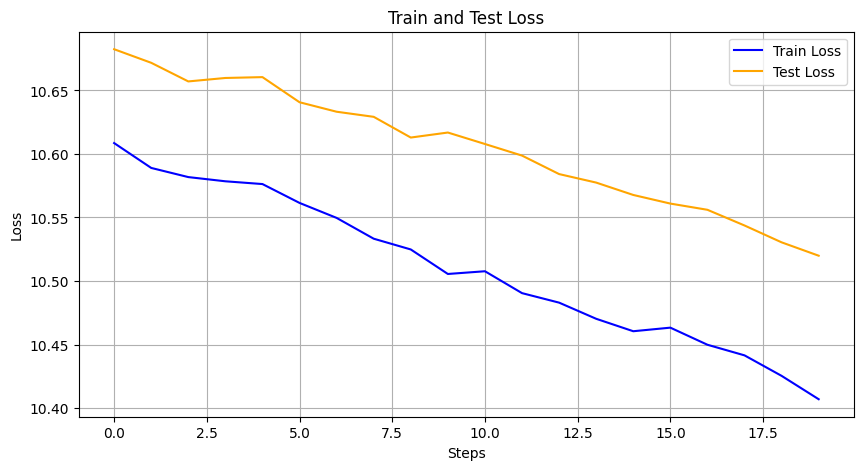

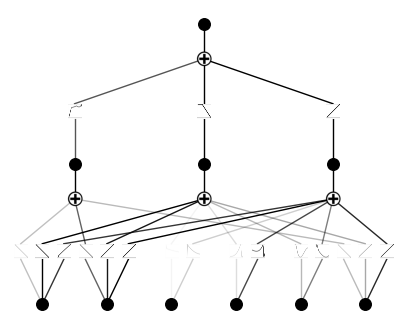

In [12]:
# train the model
res=model.fit(dataset.data_dict, opt="LBFGS", steps=20, lamb=0.1, lamb_entropy=10,lr=0.01, metrics=(train_mre,test_mre,train_mae,train_mse,test_mae,test_mse))
train_loss=res["train_loss"]
test_loss=res["test_loss"]

train_mae=res["train_mae"][-1]
train_mse=res["train_mse"][-1]
test_mae=res["test_mae"][-1]
test_mse=res["test_mse"][-1]
# 打印结果
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# 绘制损失图
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='orange')
plt.title('Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#绘制模型
model.plot()

saving model version 0.3


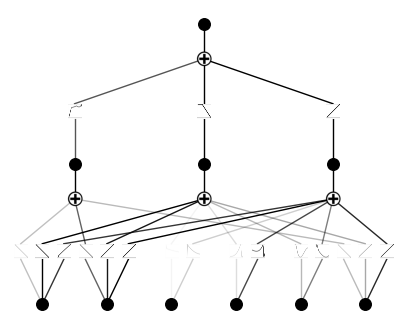

In [13]:
model.prune()
model.plot()

In [19]:
print(model.attribute())

None


In [20]:
model.feature_score

tensor([2.3129, 2.5028, 0.0795, 0.3483, 0.2806, 0.6209], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [21]:
model.edge_scores_all

[tensor([[[8.4119e-02, 2.3966e-01, 4.4134e-05, 3.3647e-04, 1.9887e-05,
           9.1968e-02],
          [1.8654e+00, 5.1775e-01, 1.4612e-02, 4.5312e-02, 9.4668e-02,
           1.1823e-01],
          [3.6342e-01, 1.7453e+00, 6.4872e-02, 3.0263e-01, 1.8594e-01,
           4.1074e-01]]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[[0.2687, 1.9665, 1.9214]]], device='cuda:0', grad_fn=<MulBackward0>)]

第二次训练+网格细化（第三次训练？？？）+第四次训练

| train_loss: 1.07e+01 | test_loss: 1.09e+01 | reg: 5.71e+01 | : 100%|█| 20/20 [00:50<00:00,  2.54s/


saving model version 0.3
Train MAE: 7.3278
Train MSE: 115.1585
Test MAE: 7.4679
Test MSE: 118.1335


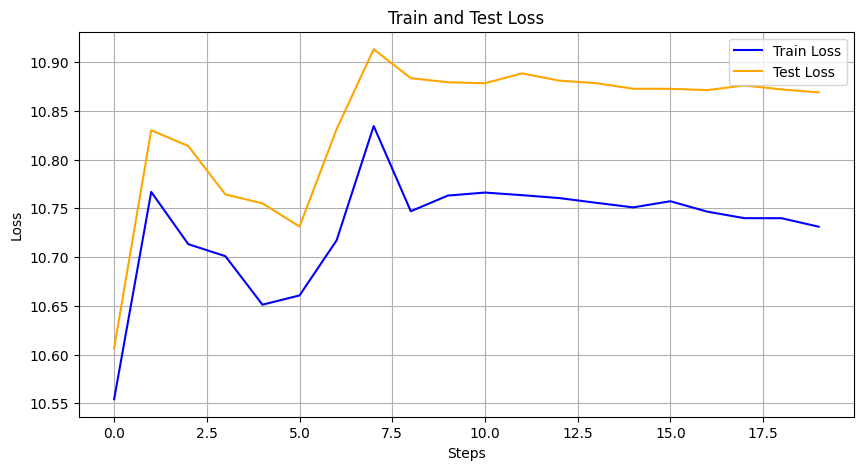

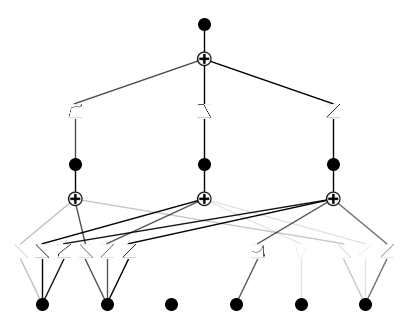

In [24]:
# train the model
res=model.fit(dataset.data_dict, opt="LBFGS", steps=20, lamb=1, lamb_entropy=10,lr=0.01, metrics=(train_mae,train_mse,test_mae,test_mse))
train_loss=res["train_loss"]
test_loss=res["test_loss"]

train_mae=res["train_mae"][-1]
train_mse=res["train_mse"][-1]
test_mae=res["test_mae"][-1]
test_mse=res["test_mse"][-1]
# 打印结果
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# 绘制损失图
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='orange')
plt.title('Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#绘制模型
model.plot()

In [25]:
model = model.refine(10)

saving model version 0.4











































| train_loss: 1.01e+01 | test_loss: 1.02e+01 | reg: 8.91e+01 | : 100%|█| 20/20 [01:00<00:00,  3.03s/


saving model version 0.5
Train MAE: 6.7159
Train MSE: 101.9394
Test MAE: 6.8756
Test MSE: 104.7860


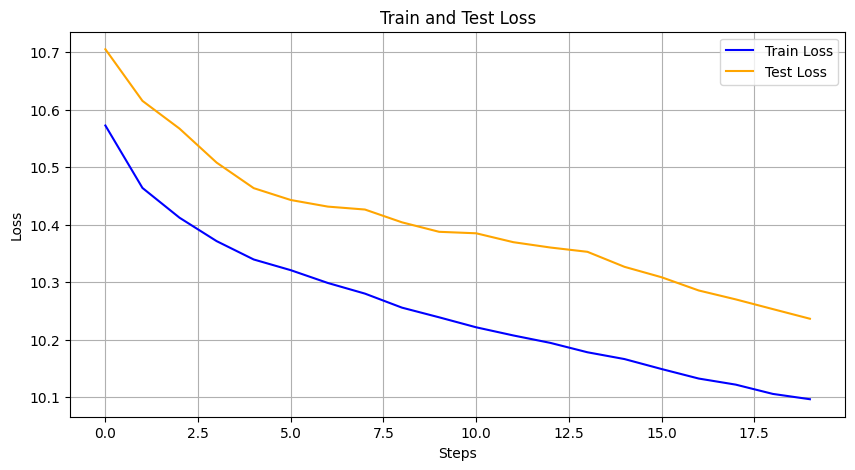

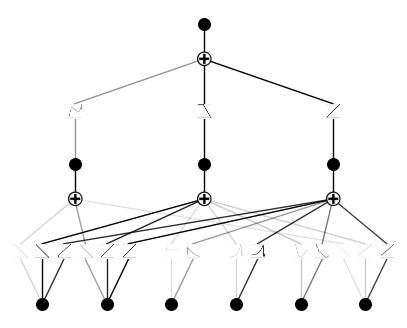

In [28]:
# train the model
res=model.fit(dataset.data_dict, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10, metrics=(train_mae,train_mse,test_mae,test_mse))
train_loss=res["train_loss"]
test_loss=res["test_loss"]

train_mae=res["train_mae"][-1]
train_mse=res["train_mse"][-1]
test_mae=res["test_mae"][-1]
test_mse=res["test_mse"][-1]
# 打印结果
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# 绘制损失图
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='orange')
plt.title('Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#绘制模型
model.plot()

符号回归

In [29]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.9998811483383179, c=1
fixing (0,0,1) with x, r2=0.9997764825820923, c=1
fixing (0,0,2) with x, r2=0.9422662854194641, c=1
fixing (0,1,0) with x, r2=0.9997842907905579, c=1
fixing (0,1,1) with x, r2=0.9998570680618286, c=1
fixing (0,1,2) with x, r2=0.9993091821670532, c=1
fixing (0,2,0) with x, r2=0.818845272064209, c=1
fixing (0,2,1) with x, r2=0.11362934112548828, c=1
fixing (0,2,2) with x, r2=0.037233877927064896, c=1
fixing (0,3,0) with x, r2=0.9854490756988525, c=1
fixing (0,3,1) with x, r2=0.00043893494876101613, c=1
fixing (0,3,2) with x, r2=0.004063760861754417, c=1
fixing (0,4,0) with x, r2=0.1843448281288147, c=1
fixing (0,4,1) with x, r2=0.7891795039176941, c=1
fixing (0,4,2) with x, r2=0.896077036857605, c=1
fixing (0,5,0) with x, r2=0.9995080828666687, c=1
fixing (0,5,1) with x, r2=0.4567398726940155, c=1
fixing (0,5,2) with x, r2=0.4905988872051239, c=1
fixing (1,0,0) with x, r2=0.07789694517850876, c=1
fixing (1,1,0) with x, r2=0.12010821700096

In [30]:
from kan.utils import ex_round

SR=ex_round(model.symbolic_formula()[0][0],4)
print(SR)

1.107*x_1 + 6.8722*x_2 - 29.4595*x_3 - 5.9153*x_4 - 1423.1843*x_5 + 0.72*x_6 - 9.8947
